In [6]:
using LinearAlgebra
using Plots, Plots.PlotMeasures
using Colors
using LaTeXStrings
using FFMPEG

# Set parameters

In [7]:
# define arguments
fov = 20           # fov (cm)
N = 128            # nominal matrix size
nspokes = 5        # number of lps spokes
nechoes = 2        # number of echoes
tseg = 1120        # time/segment (us)
trf = 20           # time/rf pulse (us)
fa = 4             # rf flip angle (deg)
gmax = 4           # max gradient amplitude (G/cm)
smax = 4000        # max slew rate (G/cm/s)
dt = 4             # raster time (us)
gam = 4258         # GMR of H+ (Hz/G)
T2 = 10e3          # T2 (us)

10000.0

# Create waveforms

In [20]:
# check that segment/rf widths are valid with given raster time
if tseg % dt != 0
    error("tseg must be divisible by raster time")
end
if trf % dt != 0
    error("trf must be divisible by raster time")
end

# calculate loop velocity
om = 2 * pi / (nspokes * tseg * 1e-6)

# calculate gradient amplitude & slew rate
g_amp = pi * N / gam / (tseg * 1e-6) / (nspokes * fov * 2 * sin(pi / nspokes))
s_amp = om * g_amp

# calculate ramp-up
nramp = ceil(Int, g_amp / smax / (dt * 1e-6))
ramp_up = range(0, stop=1, length=nramp)
nramp = length(ramp_up)

# calculate segment length and sample array
nseg = round(Int, tseg / dt)
n = 0:(1+nechoes) * nspokes * nseg - 1

# construct normal gradients
gx = g_amp .* cos.(om .* n .* dt .* 1e-6)
gy = g_amp .* sin.(om .* n .* dt .* 1e-6)

# calculate k-space trajectory
kx = zeros((1+nechoes) * nspokes * nseg, nspokes)
ky = zeros((1+nechoes) * nspokes * nseg, nspokes)
magS = zeros((1+nechoes) * nspokes * nseg, nspokes)
for v in 1:nspokes
    gx_v = circshift(gx, -(v-1)*nseg)[(v-1)*nseg+1:end]
    gy_v = circshift(gy, -(v-1)*nseg)[(v-1)*nseg+1:end]
    kx[(v-1)*nseg+1:end, v] = gam * dt * cumsum(gx_v) * 1e-6
    ky[(v-1)*nseg+1:end, v] = gam * dt * cumsum(gy_v) * 1e-6

    # estimate the signal magnitude for each echo
    magS[(v-1)*nseg+1:end, v] = exp.(-2*sqrt.(kx[(v-1)*nseg+1:end, v] .^ 2 .+ ky[(v-1)*nseg+1:end, v] .^ 2)) .* exp.(-(0:length(gx_v)-1) .* dt ./ T2)
end
kmax = maximum(sqrt.(kx.^2 + ky.^2))

# construct polygon gradients
g_amp_poly = N / fov / 2 / (gam * nseg * dt * 1e-6)
nramp_poly = ceil(Int, g_amp_poly / smax / (dt * 1e-6))
gx_amp_ip1 = g_amp_poly
gy_amp_ip1 = 0.0
gx_poly = Float64[]
gy_poly = Float64[]
for i in 1:(1+nechoes)*nspokes
    gx_amp_i = gx_amp_ip1
    gx_amp_ip1 = g_amp_poly * cos(om * nseg * i * dt * 1e-6)
    append!(gx_poly, fill(gx_amp_i, nseg))
    append!(gx_poly, range(gx_amp_i, stop=gx_amp_ip1, length=nramp_poly))
    
    gy_amp_i = gy_amp_ip1
    gy_amp_ip1 = g_amp_poly * sin(om * nseg * i * dt * 1e-6)
    append!(gy_poly, fill(gy_amp_i, nseg))
    append!(gy_poly, range(gy_amp_i, stop=gy_amp_ip1, length=nramp_poly))
end

# calculate k-space trajectory for polygon
len_poly = (1+nechoes) * nspokes * (nseg + nramp_poly)
kx_poly = zeros(len_poly, nspokes)
ky_poly = zeros(len_poly, nspokes)
magS_poly = zeros(len_poly, nspokes)
for v in 1:nspokes
    gx_poly_v = circshift(gx_poly, -(v - 1) * (nseg + nramp_poly))[(v-1)*(nseg+nramp_poly)+1:end]
    gy_poly_v = circshift(gy_poly, -(v - 1) * (nseg + nramp_poly))[(v-1)*(nseg+nramp_poly)+1:end]
    kx_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = gam * dt * cumsum(gx_poly_v) * 1e-6
    ky_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = gam * dt * cumsum(gy_poly_v) * 1e-6

    # estimate the signal magnitude for each echo
    magS_poly[(v-1)*(nseg+nramp_poly)+1:end, v] = exp.(-2*sqrt.(kx_poly[(v-1)*(nseg+nramp_poly)+1:end, v] .^ 2 .+ ky_poly[(v-1)*(nseg+nramp_poly)+1:end, v] .^ 2)) .* exp.(-(0:length(gx_poly_v)-1) .* dt ./ T2)
end

# remove last ramp
len_poly -= nramp_poly
gx_poly = gx_poly[1:len_poly]
gy_poly = gy_poly[1:len_poly]
kx_poly = kx_poly[1:len_poly, :]
ky_poly = ky_poly[1:len_poly, :]
magS_poly = magS_poly[1:len_poly, :]

# get max kspace
kmax_poly = maximum(sqrt.(kx_poly.^2 + ky_poly.^2))

# calculate rf amplitude
rf_amp = fa / (360 * gam * trf) # (G)

# construct rf burst pulse
nrf = round(Int, trf / dt)
n = 0:(nspokes-1)*nseg + nrf - 1
rf = rf_amp .* ((mod.(n, nseg) .< nrf) .& (n .< nspokes*nseg))
rf = vcat(rf, zeros((1+nechoes) * nspokes * nseg - length(rf)))
n_poly = 0:(nspokes-1)*(nseg + nramp_poly) + nrf - 1
rf_poly = rf_amp .* ((mod.(n_poly, nseg+nramp_poly) .< nrf) .& (n_poly .< nspokes*(nseg+nramp_poly)))
rf_poly = vcat(rf_poly, zeros(len_poly - length(rf_poly)))

# Color definitions (replace hex2rgb with RGB values or use Colors.jl if needed)
red = RGB(0x9A/255, 0x33/255, 0x24/255)
orange = RGB(0xD8/255, 0x60/255, 0x18/255)
green = RGB(0x75/255, 0x98/255, 0x8d/255)
teal = RGB(0x00/255, 0xB2/255, 0xA9/255)
blue = RGB(0x2F/255, 0x65/255, 0xA7/255)
dblue = RGB(0x00/255, 0x27/255, 0x4C/255)
amethyst = RGB(0x70/255, 0x20/255, 0x82/255)
maize = RGB(0xFF/255, 0xCB/255, 0x05/255)
rmspec = [maize .* (i/(nspokes-1)) + red .* (1-i/(nspokes-1)) for i in 0:nspokes-2];


# define plotting functions

In [80]:
function plot_sequence(t, gx, gy, rf, acq, magS; i=length(t), tlim=(minimum(t),maximum(t)), title="")

    # plot the gradients and rf
    pseq = plot(t, gx / g_amp,
        xlim=tlim, ylim=(-1.1, 1.1),
        title=false,
        color=dblue,
        label=L"g_x",
        xticks=false, yticks=false,
        legend=:bottomright,
        xlabel="", ylabel=L"")
    plot!(pseq,
        t, gy / g_amp,
        color=dblue,
        line=:dash,
        label=L"g_y",)
    plot!(pseq,
        t, rf / rf_amp,
        title=title,
        color=red,
        label=L"RF",
        xticks=false, yticks=false,
        fill=(0, :auto),
        xlabel="", ylabel="")

    # plot the magnitude signal and fill under the curve
    pms = plot(t[1:i], magS[1:i, 1],
        xlim=tlim, ylim=(0, 1.1 * maximum(magS)),
        title="Signal Magnitude",
        color=blue,
        label=false,
        xticks=false, yticks=false,
        legend=:topright,
        xlabel="Time",
        fill=(0, :auto))
    for v in 2:nspokes
        plot!(pms,
            t[1:i], magS[1:i, v],
            color=rmspec[v-1],
            label=false,
            fill=(0, :auto))
    end
    plot!(pms,
        t[1:i], acq[1:i, 1],
        color=:green,
        alpha=0.15,
        label="ACQ",
        fill=(0, :auto))

    # plot moving time indicator
    if i < length(t)
        vline!(pseq, [t[i]], line=(:black, :dash), label=false)
        vline!(pms, [t[i]], line=(:black, :dash), label=false)
    end

    # combine the pulse sequence plots into a tall stack
    ptime = plot(
        pseq, pms,
        layout=grid(2, 1, heights=[0.7, 0.3]),
        linkx=true,
        margin=3mm,
        bottom_margin=5mm,
        left_margin=8mm,
        right_margin=2mm,
    )

    return ptime
end

function plot_kspace(kx, ky; i=size(kx,1), kcutoff=0.5, kmax=maximum(sqrt.(kx[:].^2+ky[:].^2)))

    # plot the kspace trajectory for each spoke
    pks = plot(cos.(0:0.01:2*pi) .* N / fov / 2 * kcutoff,
        sin.(0:0.01:2*pi) .* N / fov / 2 * kcutoff,
        xlim=(-1.1 * kmax, 1.1 * kmax),
        ylim=(-1.1 * kmax, 1.1 * kmax),
        aspect_ratio=1,
        xticks=false, yticks=false,
        xlabel=L"k_x", ylabel=L"k_y",
        title="K-space Trajectory",
        color=green,
        label=false,
        fill=(0, :auto),  # fill the circle to the center
        alpha=0.15)
    annotate!(pks,
        (0.5 + (N / fov / 2 * kcutoff / (kmax * 1.1)) / 1.75,
            0.5 - (N / fov / 2 * kcutoff / (kmax * 1.1)) / 1.75),
        text(L"\frac{N}{2FOV}", green, :center, 12))
    plot!(pks, kx[1:i, 1], ky[1:i, 1],
        color=blue,
        label=false)
    scatter!(pks,
        [kx[i, 1]], [ky[i, 1]],
        marker=:star,
        color=blue, markerstrokecolor=:transparent,
        label=false)
    for v in 2:nspokes
        #if i > (v - 1) * nseg + nramp
            plot!(pks,
                kx[1:i, v], ky[1:i, v],
                color=rmspec[v-1],
                label=false)
            scatter!(pks,
                [kx[i, v]], [ky[i, v]],
                marker=:star,
                color=rmspec[v-1], markerstrokecolor=:transparent,
                label=false)
        #end
    end

    # compact k-space trajectory plot
    pks = plot(pks,
        margin=5mm,
        bottom_margin=5mm,
        left_margin=8mm,
        right_margin=2mm,
    )

    return pks
end

function plot_all(ptime,pks)
    plot(
        ptime, pks,
        layout=grid(1, 2, widths=[0.6, 0.4]),
        size=(1200, 450),
        margin=2mm,
        bottom_margin=8mm,
        left_margin=10mm,
        right_margin=5mm,
    )
end

plot_all (generic function with 1 method)

# Plot single-spoke ZTE sequence

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/zte.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/zte.gif")
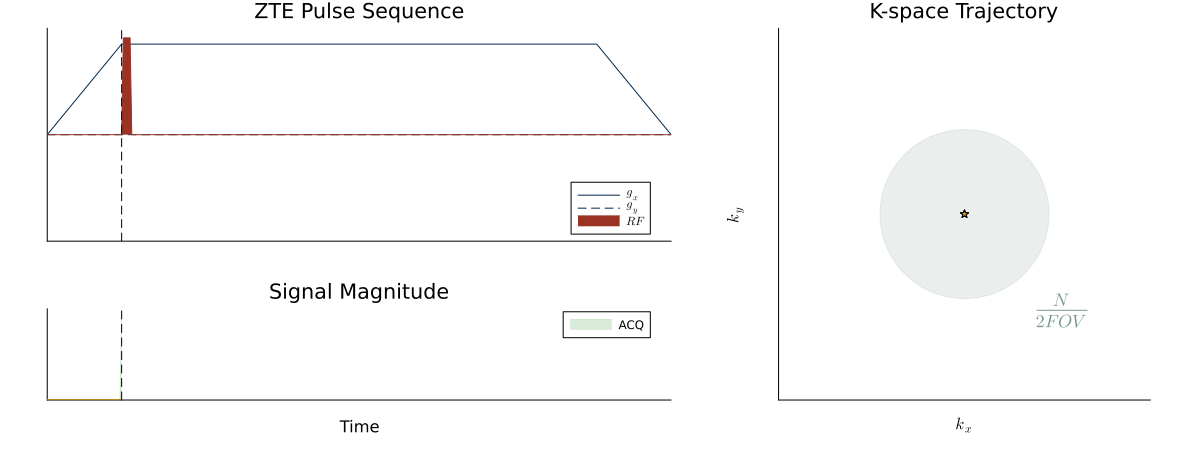

In [92]:
# k-space cutoff
kcutoff = 0.5;

# get the time for the section
t_zte = (0:nseg+2*nramp-1) * dt

# get (single spoke) ZTE section and add ramps
gx_zte = vcat(gx_poly[1] * ramp_up, gx_poly[1:nseg], gx_poly[nseg] * reverse(ramp_up))
gy_zte = vcat(gy_poly[1] * ramp_up, gy_poly[1:nseg], gy_poly[nseg] * reverse(ramp_up))
rf_zte = vcat(zeros(nramp), rf_poly[1:nseg], zeros(nramp))
kx_zte = vcat(zeros(nramp, nspokes), kx_poly[1:nseg, :], kx_poly[nseg, :]' .* ones(nramp, nspokes))
ky_zte = vcat(zeros(nramp, nspokes), ky_poly[1:nseg, :], ky_poly[nseg, :]' .* ones(nramp, nspokes))
magS_zte = vcat(zeros(nramp, nspokes), magS_poly[1:nseg, :], magS_poly[nseg, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq_zte = (sqrt.(kx_zte .^ 2 .+ ky_zte .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_zte, 1)) .- nseg * (0:nspokes-1)' .>= nramp)
acq_zte = sum(1 * acq_zte, dims=2);

# create the animation
anim_zte = @animate for i in nramp:5:nseg+nramp # full sequence

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_zte, gx_zte, gy_zte, rf_zte, acq_zte, magS_zte; i=i, title="ZTE Pulse Sequence")
    pks = plot_kspace(kx_zte, ky_zte; i=i, kcutoff=kcutoff, kmax=N/fov/2)
    plot_all(ptime, pks)

end

gif(anim_zte, "compiled_figures/zte.gif", fps=30, loop=-1)

# Plot multi-spoke ZTE (RUFIS) sequence

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/zte_to_rufis.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156
┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/rufis1.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156
┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/rufis2.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/rufis2.gif")
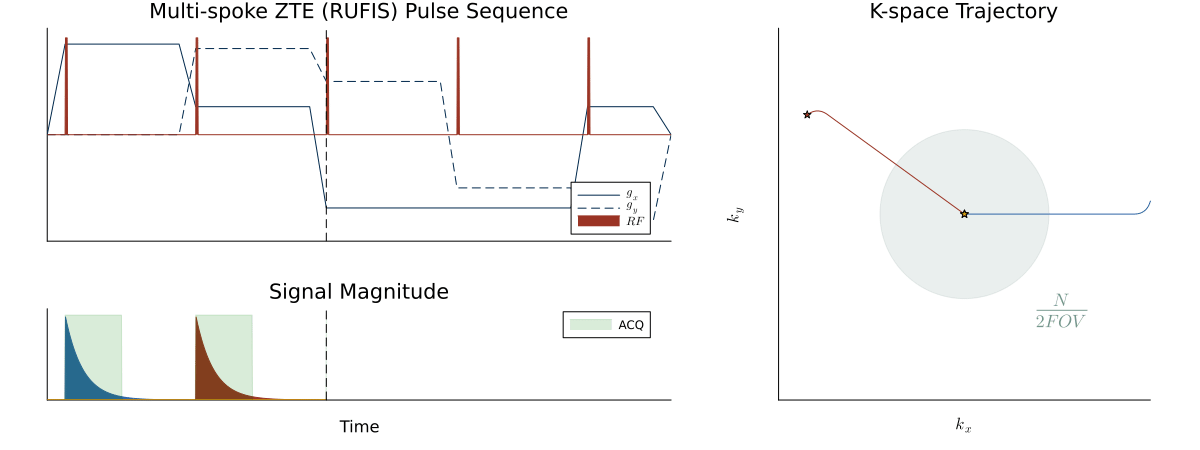

In [ ]:
# k-space cutoff
kcutoff = 0.5;

# get the time for the section
len_rufis = round(Int,(nspokes-kcutoff)*(nseg+nramp_poly));
t_rufis = (0:len_rufis+2*nramp-1) * dt

# get (single spoke) ZTE section and add ramps
gx_rufis = vcat(gx_poly[1] * ramp_up, gx_poly[1:len_rufis], gx_poly[len_rufis] * reverse(ramp_up))
gy_rufis = vcat(gy_poly[1] * ramp_up, gy_poly[1:len_rufis], gy_poly[len_rufis] * reverse(ramp_up))
rf_rufis = vcat(zeros(nramp), rf_poly[1:len_rufis], zeros(nramp))
kx_rufis = vcat(zeros(nramp, nspokes), kx_poly[1:len_rufis, :], kx_poly[len_rufis, :]' .* ones(nramp, nspokes))
ky_rufis = vcat(zeros(nramp, nspokes), ky_poly[1:len_rufis, :], ky_poly[len_rufis, :]' .* ones(nramp, nspokes))
magS_rufis = vcat(zeros(nramp, nspokes), magS_poly[1:len_rufis, :], magS_poly[len_rufis, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq_rufis = (sqrt.(kx_rufis .^ 2 .+ ky_rufis .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_rufis, 1)) .- (nseg + nramp_poly) * (0:nspokes-1)' .>= nramp)
acq_rufis = sum(1 * acq_rufis, dims=2);

# transition from ZTE to RUFIS
n_transition = length("Multi-spoke ZTE (RUFIS) ");
anim_zte_to_rufis = @animate for i in 1:2*n_transition # full sequence

    # part 1: zoom out of ZTE
    if i <= n_transition
        a = sqrt(i/n_transition) # time interpolation factor
        nletters = max(length("ZTE ") - i, 0) # number of letters to show in title

        tmax = (1-a)*(nseg + 2*nramp) * dt + a * (len_rufis + 2*nramp) * dt
        title="ZTE "[end-nletters+1:end] * "Pulse Sequence"
        ptime = plot_sequence(t_zte, gx_zte, gy_zte, rf_zte, acq_zte, magS_zte; i=(nseg + nramp)-1,  title=title, tlim=(0,tmax))
        pks = plot_kspace(kx_zte, ky_zte; i=(nseg + nramp)-1, kcutoff=kcutoff, kmax=N/fov/2)
        plot_all(ptime, pks)
    else # part 2: transition to RUFIS
        a = sqrt((i-n_transition)/n_transition) # waveform interpolation factor
        nletters = min(i-n_transition, length("Multi-spoke ZTE (RUFIS) ")) # number of letters to show in title

        gx_trans = (1-a) * vcat(gx_zte, zeros(length(gx_rufis)-length(gx_zte))) .+ a * gx_rufis
        gy_trans = (1-a) * vcat(gy_zte, zeros(length(gy_rufis)-length(gy_zte))) .+ a * gy_rufis
        rf_trans = (1-a) * vcat(rf_zte, zeros(length(rf_rufis)-length(rf_zte))) .+ a * rf_rufis
        acq_trans = (1-a) * vcat(acq_zte, zeros(length(acq_rufis)-length(acq_zte))) .+ a * acq_rufis
        magS_trans = (1-a) * vcat(magS_zte, zeros(size(magS_rufis,1)-size(magS_zte,1), size(magS_zte,2))) .+ a * magS_rufis

        # combine the pulse sequence plots into a tall stack
        title="Multi-spoke ZTE (RUFIS) "[end-nletters+1:end] * "Pulse Sequence"
        ptime = plot_sequence(t_rufis, gx_trans, gy_trans, rf_trans, acq_trans, magS_trans; i=(nseg + nramp)-1,  title=title)
        pks = plot_kspace(kx_zte, ky_zte; i=(nseg + nramp)-1, kcutoff=kcutoff, kmax=N/fov/2)
        plot_all(ptime, pks)
    end

end

gif(anim_zte_to_rufis, "compiled_figures/zte_to_rufis.gif", fps=30, loop=-1)

# create the rufis animation
anim_rufis1 = @animate for i in nramp+nseg:5:nramp+2*(nseg+nramp_poly) # 2nd spoke only

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_rufis, gx_rufis, gy_rufis, rf_rufis, acq, magS_rufis; i=i, title="Multi-spoke ZTE (RUFIS) Pulse Sequence")
    pks = plot_kspace(kx_rufis, ky_rufis; i=i, kcutoff=kcutoff, kmax=N/fov/2)
    plot_all(ptime, pks)

end

gif(anim_rufis1, "compiled_figures/rufis1.gif", fps=30, loop=-1)

anim_rufis2 = @animate for i in nramp+2*(nseg+nramp_poly):10:len_rufis+nramp # rest of the spokes

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_rufis, gx_rufis, gy_rufis, rf_rufis, acq, magS_rufis; i=i, title="Multi-spoke ZTE (RUFIS) Pulse Sequence")
    pks = plot_kspace(kx_rufis, ky_rufis; i=i, kcutoff=kcutoff, kmax=N/fov/2)
    plot_all(ptime, pks)

end

gif(anim_rufis2, "compiled_figures/rufis2.gif", fps=30, loop=-1)

anim_rufis3 = @animate for i in 1:n_transition # zoom out kspace

    a = sqrt(i/n_transition) # kmax interpolation factor

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_rufis, gx_rufis, gy_rufis, rf_rufis, acq, magS_rufis; i=len_rufis+nramp, title="Multi-spoke ZTE (RUFIS) Pulse Sequence")
    pks = plot_kspace(kx_rufis, ky_rufis; i=len_rufis+nramp, kcutoff=kcutoff, kmax=((1-a)*N/fov/2 + a*kmax_poly))
    plot_all(ptime, pks)

end

gif(anim_rufis3, "compiled_figures/rufis3.gif", fps=30, loop=-1)

# Plot (single echo) polygon looping star sequence

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/rufis_to_plps.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156
┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/plps1.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/plps1.gif")
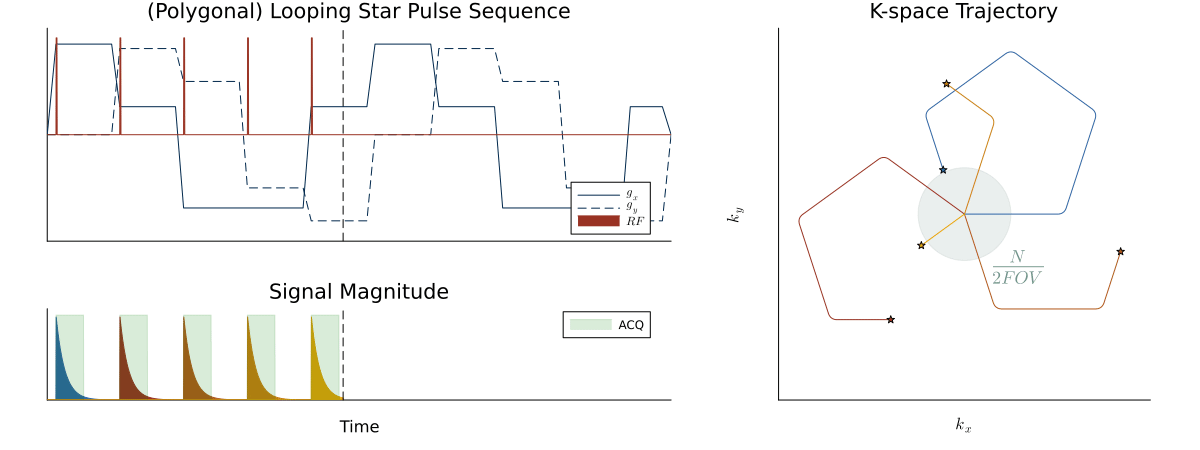

In [ ]:
# k-space cutoff
kcutoff = 0.5;

# get the time for the section
len_poly1 = round(Int,(2*nspokes-kcutoff)*(nseg+nramp_poly));
t_poly1 = (0:len_poly1+2*nramp-1) * dt

# get (single spoke) ZTE section and add ramps
gx_poly1 = vcat(gx_poly[1] * ramp_up, gx_poly[1:len_poly1], gx_poly[len_poly1] * reverse(ramp_up))
gy_poly1 = vcat(gy_poly[1] * ramp_up, gy_poly[1:len_poly1], gy_poly[len_poly1] * reverse(ramp_up))
rf_poly1 = vcat(zeros(nramp), rf_poly[1:len_poly1], zeros(nramp))
kx_poly1 = vcat(zeros(nramp, nspokes), kx_poly[1:len_poly1, :], kx_poly[len_poly1, :]' .* ones(nramp, nspokes))
ky_poly1 = vcat(zeros(nramp, nspokes), ky_poly[1:len_poly1, :], ky_poly[len_poly1, :]' .* ones(nramp, nspokes))
magS_poly1 = vcat(zeros(nramp, nspokes), magS_poly[1:len_poly1, :], magS_poly[len_poly1, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq_poly1 = (sqrt.(kx_poly1 .^ 2 .+ ky_poly1 .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_poly1, 1)) .- (nseg + nramp_poly) * (0:nspokes-1)' .>= nramp)
acq_poly1 = sum(1 * acq_poly1, dims=2);

# transition from RUFIS to polyLPS
n_transition = max(length("Multi-spoke ZTE (RUFIS) "), length("(Polygonal) Looping Star) "));
anim_rufis_to_plps = @animate for i in 1:2*n_transition # full sequence

    # part 1: zoom out of RUFIS
    if i <= n_transition
        a = sqrt(i/n_transition) # time interpolation factor
        nletters = max(length("Multi-spoke ZTE (RUFIS) ") - i, 0) # number of letters to show in title

        tmax = (1-a)*(len_rufis + 2*nramp) * dt + a * (len_poly1 + 2*nramp) * dt
        title="Multi-spoke ZTE (RUFIS) "[end-nletters+1:end] * "Pulse Sequence"
        ptime = plot_sequence(t_rufis, gx_rufis, gy_rufis, rf_rufis, acq_rufis, magS_rufis; i=(len_rufis + nramp)-1,  title=title, tlim=(0,tmax))
        pks = plot_kspace(kx_rufis, ky_rufis; i=(len_rufis + nramp)-1, kcutoff=kcutoff, kmax=kmax_poly)
        plot_all(ptime, pks)

    else # part 2: transition to polyLPS
        a = sqrt((i-n_transition)/n_transition) # waveform interpolation factor
        nletters = min(i-n_transition, length("(Polygonal) Looping Star ")) # number of letters to show in title

        gx_trans = (1-a) * vcat(gx_rufis, zeros(length(gx_poly1)-length(gx_rufis))) .+ a * gx_poly1
        gy_trans = (1-a) * vcat(gy_rufis, zeros(length(gy_poly1)-length(gy_rufis))) .+ a * gy_poly1
        rf_trans = (1-a) * vcat(rf_rufis, zeros(length(rf_poly1)-length(rf_rufis))) .+ a * rf_poly1
        acq_trans = (1-a) * vcat(acq_rufis, zeros(length(acq_poly1)-length(acq_rufis))) .+ a * acq_poly1
        magS_trans = (1-a) * vcat(magS_rufis, zeros(size(magS_poly1,1)-size(magS_rufis,1), size(magS_rufis,2))) .+ a * magS_poly1

        # combine the pulse sequence plots into a tall stack
        title="(Polygonal) Looping Star "[end-nletters+1:end] * "Pulse Sequence"
        ptime = plot_sequence(t_poly1, gx_trans, gy_trans, rf_trans, acq_trans, magS_trans; i=(len_rufis + nramp)-1,  title=title)
        pks = plot_kspace(kx_poly1, ky_poly1; i=(len_rufis + nramp)-1, kcutoff=kcutoff, kmax=kmax_poly)
        plot_all(ptime, pks)
    end

end

gif(anim_rufis_to_plps, "compiled_figures/rufis_to_plps.gif", fps=30, loop=-1)

# create the plps animation
anim_plps1 = @animate for i in nramp+len_rufis:5:nramp+nspokes*(nseg+nramp_poly) # 1st spoke-in only

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_poly1, gx_poly1, gy_poly1, rf_poly1, acq_poly1, magS_poly1; i=i, title="(Polygonal) Looping Star Pulse Sequence")
    pks = plot_kspace(kx_poly1, ky_poly1; i=i, kcutoff=kcutoff, kmax=kmax_poly)
    plot_all(ptime, pks)

end

gif(anim_plps1, "compiled_figures/plps1.gif", fps=30, loop=-1)

# create the plps animation
anim_plps2 = @animate for i in nramp+nspokes*(nseg+nramp_poly):5:nramp+nspokes*(nseg+nramp_poly)+round(Int,nseg*kcutoff) # 1st spoke-out only

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_poly1, gx_poly1, gy_poly1, rf_poly1, acq_poly1, magS_poly1; i=i, title="(Polygonal) Looping Star Pulse Sequence")
    pks = plot_kspace(kx_poly1, ky_poly1; i=i, kcutoff=kcutoff, kmax=kmax_poly)
    plot_all(ptime, pks)

end

gif(anim_plps2, "compiled_figures/plps2.gif", fps=30, loop=-1)

# create the plps animation
anim_plps3 = @animate for i in nramp+nspokes*(nseg+nramp_poly)+round(Int,nseg*kcutoff):10:nramp+len_poly1 # rest of spokes

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_poly1, gx_poly1, gy_poly1, rf_poly1, acq_poly1, magS_poly1; i=i, title="(Polygonal) Looping Star Pulse Sequence")
    pks = plot_kspace(kx_poly1, ky_poly1; i=i, kcutoff=kcutoff, kmax=kmax_poly)
    plot_all(ptime, pks)

end

gif(anim_plps3, "compiled_figures/plps3.gif", fps=30, loop=-1)


# Create multi-echo polygonal LPS

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/plps_to_meplps.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156
┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/meplps.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/meplps.gif")
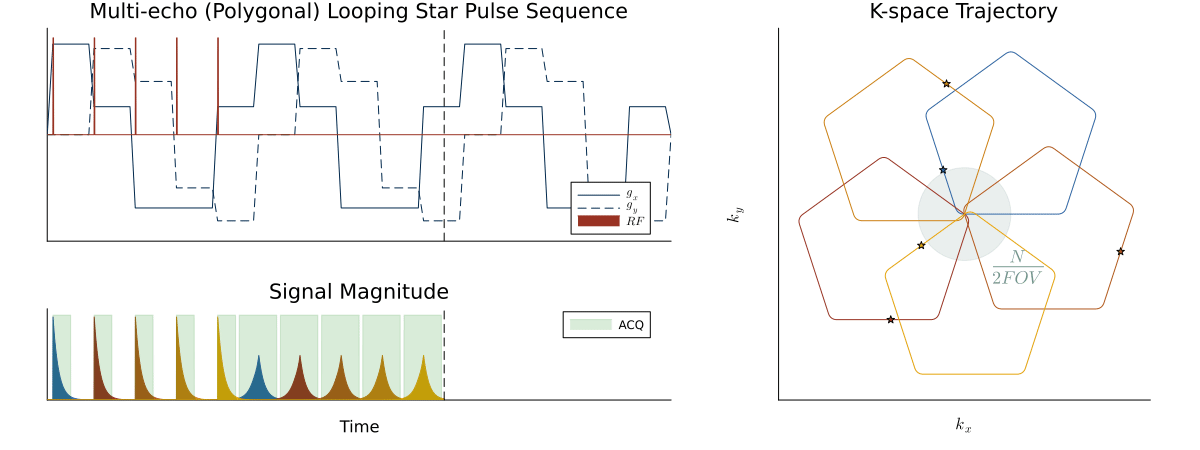

In [ ]:
t_poly2 = (0:len_poly+2*nramp-1) * dt

# add ramps
gx_poly2 = vcat(gx_poly[1] * ramp_up, gx_poly, gx_poly[end] * reverse(ramp_up))
gy_poly2 = vcat(gy_poly[1] * ramp_up, gy_poly, gy_poly[end] * reverse(ramp_up))
rf_poly2 = vcat(zeros(nramp), rf_poly, zeros(nramp))
kx_poly2 = vcat(zeros(nramp, nspokes), kx_poly, kx_poly[end, :]' .* ones(nramp, nspokes))
ky_poly2 = vcat(zeros(nramp, nspokes), ky_poly, ky_poly[end, :]' .* ones(nramp, nspokes))
magS_poly2 = vcat(zeros(nramp, nspokes), magS_poly, magS_poly[end, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq_poly2 = (sqrt.(kx_poly2 .^ 2 .+ ky_poly2 .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_poly2, 1)) .- (nseg + nramp_poly) * (0:nspokes-1)' .>= nramp)
acq_poly2 = sum(1 * acq_poly2, dims=2);

# transition from RUFIS to polyLPS
n_transition = length("Multi-echo ");
anim_plps_to_meplps = @animate for i in 1:2*n_transition # full sequence

    # part 1: zoom out of RUFIS
    if i <= n_transition
        a = sqrt(i/n_transition) # time interpolation factor
        tmax = (1-a)*(len_poly1 + 2*nramp) * dt + a * (len_poly + 2*nramp) * dt
        ptime = plot_sequence(t_poly1, gx_poly1, gy_poly1, rf_poly1, acq_poly1, magS_poly1; i=(len_poly1 + nramp)-1,  title="(Polygonal) Looping Star ", tlim=(0,tmax))
        pks = plot_kspace(kx_poly1, ky_poly1; i=(len_poly1 + nramp)-1, kcutoff=kcutoff, kmax=kmax_poly)
        plot_all(ptime, pks)

    else # part 2: transition to polyLPS
        a = sqrt((i-n_transition)/n_transition) # waveform interpolation factor
        nletters = min(i-n_transition, length("Multi-echo ")) # number of letters to show in title

        gx_trans = (1-a) * vcat(gx_poly1, zeros(length(gx_poly2)-length(gx_poly1))) .+ a * gx_poly2
        gy_trans = (1-a) * vcat(gy_poly1, zeros(length(gy_poly2)-length(gy_poly1))) .+ a * gy_poly2
        rf_trans = (1-a) * vcat(rf_poly1, zeros(length(rf_poly2)-length(rf_poly1))) .+ a * rf_poly2
        acq_trans = (1-a) * vcat(acq_poly1, zeros(length(acq_poly2)-length(acq_poly1))) .+ a * acq_poly2
        magS_trans = (1-a) * vcat(magS_poly1, zeros(size(magS_poly2,1)-size(magS_poly1,1), size(magS_poly2,2))) .+ a * magS_poly2

        # combine the pulse sequence plots into a tall stack
        title="Multi-echo "[end-nletters+1:end] * "(Polygonal) Looping Star Pulse Sequence"
        ptime = plot_sequence(t_poly2, gx_trans, gy_trans, rf_trans, acq_trans, magS_trans; i=(len_poly1 + nramp)-1,  title=title)
        pks = plot_kspace(kx_poly2, ky_poly2; i=(len_poly1 + nramp)-1, kcutoff=kcutoff, kmax=kmax_poly)
        plot_all(ptime, pks)
    end

end

gif(anim_plps_to_meplps, "compiled_figures/plps_to_meplps.gif", fps=30, loop=-1)

# create the plps animation
anim_meplps = @animate for i in vcat(nramp+len_poly1:20:nramp+len_poly, nramp+len_poly) # 1st spoke-in only

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_poly2, gx_poly2, gy_poly2, rf_poly2, acq_poly2, magS_poly2; i=i, title="Multi-echo (Polygonal) Looping Star Pulse Sequence")
    pks = plot_kspace(kx_poly2, ky_poly2; i=i, kcutoff=kcutoff, kmax=kmax_poly)
    plot_all(ptime, pks)

end

gif(anim_meplps, "compiled_figures/meplps.gif", fps=30, loop=-1)

# Plot sinusoidal looping star sequence

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/meplps_to_melps.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156
┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/melps.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/melps.gif")
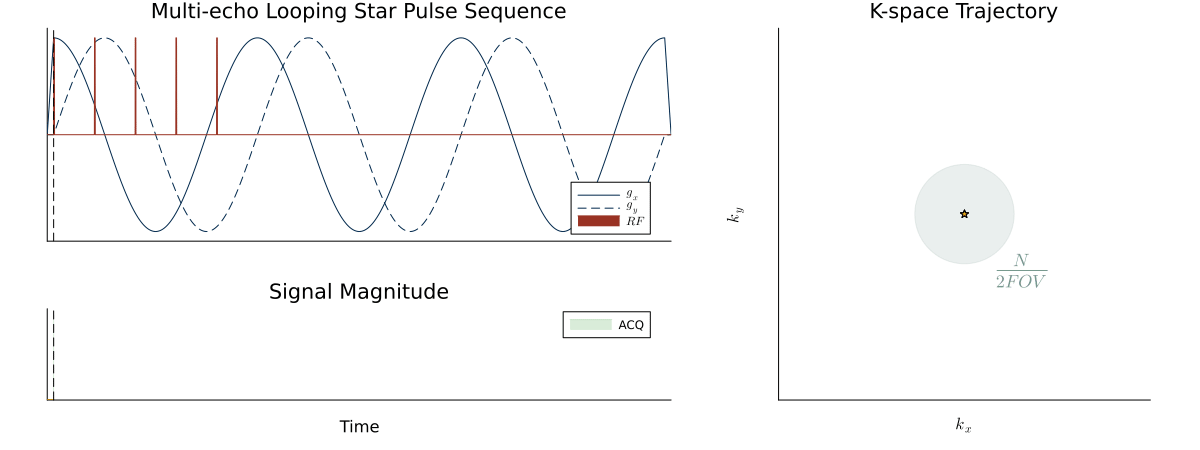

In [ ]:
len_lps = round(Int,(nechoes+1)*nspokes*nseg);
t_lps = (0:len_lps+2*nramp-1) * dt

# add ramps
gx_lps = vcat(gx[1] * ramp_up, gx[1:len_lps], gx[len_lps] * reverse(ramp_up))
gy_lps = vcat(gy[1] * ramp_up, gy[1:len_lps], gy[len_lps] * reverse(ramp_up))
rf_lps = vcat(zeros(nramp), rf[1:len_lps], zeros(nramp))
kx_lps = vcat(zeros(nramp, nspokes), kx[1:len_lps,:], kx[len_lps, :]' .* ones(nramp, nspokes))
ky_lps = vcat(zeros(nramp, nspokes), ky[1:len_lps,:], ky[len_lps, :]' .* ones(nramp, nspokes))
magS_lps = vcat(zeros(nramp, nspokes), magS[1:len_lps,:], magS[len_lps, :]' .* ones(nramp, nspokes))

# create the acquisition window waveform
acq_lps = (sqrt.(kx_lps .^ 2 .+ ky_lps .^ 2) .< kcutoff * N / fov / 2) .* ((1:size(kx_lps, 1)) .- nseg * (0:nspokes-1)' .>= nramp)
acq_lps = sum(1 * acq_lps, dims=2);

# transition from RUFIS to polyLPS
n_transition = length("(Polygonal) ");
anim_meplps_to_melps = @animate for i in 1:n_transition # full sequence

    a = sqrt(i/n_transition) # waveform interpolation factor
    nletters = max(length("(Polygonal) ") - i, 0) # number of letters to show in title
    tmax = (1-a)*(len_poly + 2*nramp) * dt + a * (len_lps + 2*nramp) * dt
    krmax = (1-a)*kmax_poly + a*kmax
    j = round.(Int, range(nramp, len_poly + nramp, n_transition))[end-i+1];

    if len_poly < len_lps
        gx_trans = (1-a) * vcat(gx_poly2, zeros(length(gx_lps)-length(gx_poly2))) .+ a * gx_lps
        gy_trans = (1-a) * vcat(gy_poly2, zeros(length(gy_lps)-length(gy_poly2))) .+ a * gy_lps
        rf_trans = (1-a) * vcat(rf_poly2, zeros(length(rf_lps)-length(rf_poly2))) .+ a * rf_lps
        acq_trans = (1-a) * vcat(acq_poly2, zeros(length(acq_lps)-length(acq_poly2))) .+ a * acq_lps
        magS_trans = (1-a) * vcat(magS_poly2, zeros(size(magS_lps,1)-size(magS_poly2,1), size(magS_poly2,2))) .+ a * magS_lps
        kx_trans = (1-a) * vcat(kx_poly2, zeros(size(kx_lps,1)-size(kx_poly2,1), size(kx_poly2,2))) .+ a * kx_lps
        ky_trans = (1-a) * vcat(ky_poly2, zeros(size(ky_lps,1)-size(ky_poly2,1), size(ky_poly2,2))) .+ a * ky_lps
    else
        gx_trans = (1-a) * gx_poly2 .+ a * vcat(gx_lps, zeros(length(gx_poly2)-length(gx_lps)))
        gy_trans = (1-a) * gy_poly2 .+ a * vcat(gy_lps, zeros(length(gy_poly2)-length(gy_lps)))
        rf_trans = (1-a) * rf_poly2 .+ a * vcat(rf_lps, zeros(length(rf_poly2)-length(rf_lps)))
        acq_trans = (1-a) * acq_poly2 .+ a * vcat(acq_lps, zeros(length(acq_poly2)-length(acq_lps)))
        magS_trans = (1-a) * magS_poly2 .+ a * vcat(magS_lps, zeros(size(magS_poly2,1)-size(magS_lps,1), size(magS_lps,2)))
        kx_trans = (1-a) * kx_poly2 .+ a * vcat(kx_lps, zeros(size(kx_poly2,1)-size(kx_lps,1), size(kx_lps,2)))
        ky_trans = (1-a) * ky_poly2 .+ a * vcat(ky_lps, zeros(size(ky_poly2,1)-size(ky_lps,1), size(ky_lps,2)))
    end

    # combine the pulse sequence plots into a tall stack
    title="Multi-echo " * "(Polygonal) "[end-nletters+1:end] * "Looping Star Pulse Sequence"
    ptime = plot_sequence(max(t_poly2,t_lps), gx_trans, gy_trans, rf_trans, acq_trans, magS_trans; i=j, tlim=(0,tmax), title=title)
    pks = plot_kspace(kx_trans, ky_trans; i=j, kcutoff=kcutoff, kmax=krmax)
    plot_all(ptime, pks)

end

gif(anim_meplps_to_melps, "compiled_figures/meplps_to_melps.gif", fps=30, loop=-1)

# create the lps animation
anim_melps = @animate for i in vcat(nramp:20:len_lps+nramp + round(Int,nseg*(kcutoff-1)), len_lps+nramp + round(Int,nseg*(kcutoff-1)))

    # combine the pulse sequence plots into a tall stack
    ptime = plot_sequence(t_lps, gx_lps, gy_lps, rf_lps, acq_lps, magS_lps; i=i, title="Multi-echo Looping Star Pulse Sequence")
    pks = plot_kspace(kx_lps, ky_lps; i=i, kcutoff=kcutoff, kmax=kmax)
    plot_all(ptime, pks)

end

gif(anim_melps, "compiled_figures/melps.gif", fps=30, loop=-1)